In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import utm


## Load data

In [10]:
agg_data = r"C:\Users\johnk\Documents\projects\kyle\j0002\test_data\2200168_agg_preliminary.csv"
mag_data = r"C:\Users\johnk\Documents\projects\kyle\j0002\test_data\2200168_mag_ags_preliminary.csv"

data_obj = pd.read_csv(agg_data).to_xarray()

In [47]:
data_by_line = data_obj.groupby("Line")

# retrieve the line
line_ids = []
for group, group_ds in data_by_line:
    variable_keys = group_ds.keys()
    line_ids.append(group)


288


Number of lines in input: 288


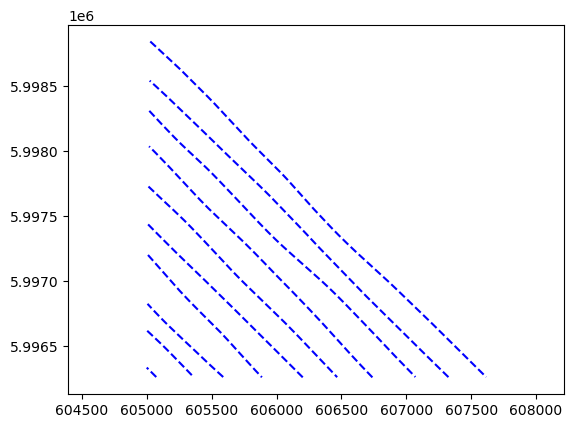

In [76]:
# store the amount of lines for historian purposes
number_of_lines = len(line_ids)
print(f"Number of lines in input: {number_of_lines}")

# get altitude for a line
ii = 0

diff_height = data_by_line[line_ids[ii]].Altitude - data_by_line[line_ids[ii]].Altitude_SRTM

# holder for possible bad data entry
problem_data = []

for ii in range(10):
    try:
        # get location information
        x, y, zone, letter = utm.from_latlon(data_by_line[line_ids[ii]].Latitude.to_numpy(), data_by_line[line_ids[ii]].Longitude.to_numpy())
        # plt.plot(diff_height, '.')
        # y = data_by_line[line_ids[ii]].Latitude.to_numpy()
        # x = data_by_line[line_ids[ii]].Longitude.to_numpy()
        plt.plot(x, y, '--b')
    except Exception as e:
        problem_data.append(ii)
        print(f" error with {e} \n\n {x}, \n\n {y} \n\n")
plt.axis('equal')
plt.show()

### Method for calculating line spacing analysis
- points are measured against each line looking for spacing more than allowed

C:\Users\johnk\AppData\Local\Temp\ipykernel_17900\2453043266.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), rotation=90)


Text(0.5, 1.0, 'line spacing analysis: portions exceeding 300.0m')

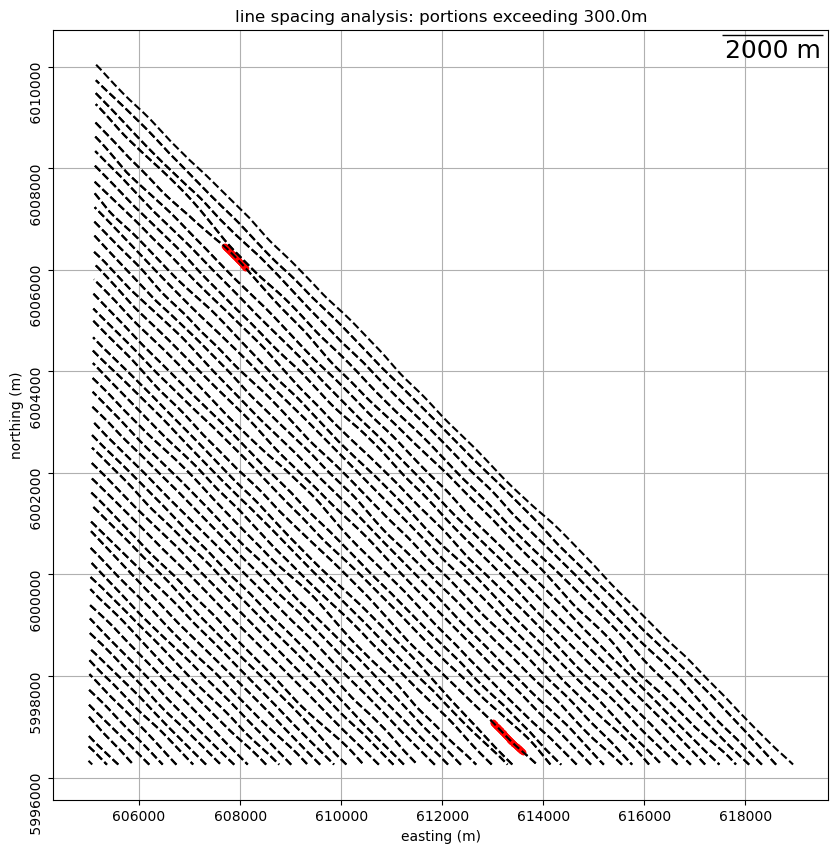

In [165]:
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)

line_seperation = 200
problem_dict = {}

fig, ax = plt.subplots(1,1, figsize=(10, 10))

# from sklearn.neighbors import NearestNeighbors
ii = 1
for ii in range(1, 50):
    x, y, zone, letter = utm.from_latlon(data_by_line[line_ids[ii]].Latitude.to_numpy(), data_by_line[line_ids[ii]].Longitude.to_numpy())
    x2, y2, zone2, letter2 = utm.from_latlon(data_by_line[line_ids[ii-1]].Latitude.to_numpy(), data_by_line[line_ids[ii-1]].Longitude.to_numpy())
    samples = np.vstack([x, y]).T
    samples2 = np.vstack([x2, y2]).T

    # in case of lines shorter than the other need use proper order to get distance
    xmax = np.max(x)
    xmin = np.min(x)
    ymax = np.max(y)
    ymin = np.min(y)

    dist = np.sqrt(np.sum(np.array([(xmax - xmin), (ymax - ymin)])**2))

    xmax2 = np.max(x2)
    xmin2 = np.min(x2)
    ymax2 = np.max(y2)
    ymin2 = np.min(y2)

    dist2 = np.sqrt(np.sum(np.array([(xmax2 - xmin2), (ymax2 - ymin2)])**2))
    # print(samples.shape, dist, dist2)
    ax.plot(x, y, '--k')
    ax.plot(x2, y2, '--k')

    if dist > dist2:
        # fit longer line and query the smallest
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(samples)
        idx_pick = neigh.kneighbors(samples2)

    else:
        # use opposite line assignment to determine line deviation
        # fit longer line and query the smallest
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(samples2)
        idx_pick = neigh.kneighbors(samples)

    # check to see if any points are over 1.5x distance
    if (idx_pick[0] > (line_seperation* 1.5)).sum() > 0:
        
        # find where they are
        find_excess_distance = np.where(idx_pick[0] > (line_seperation* 1.5))

        # grab the offending points
        # if dist > dist2:
        excess_points = samples[idx_pick[1][find_excess_distance]]
        # else:
        #     excess_points = samples2[idx_pick[1][find_excess_distance]]

        # add the points to the plot
        ax.plot(excess_points[:, 0], excess_points[:, 1], '.r')

# pretty up the plot
ax.grid(True)
ax.set_yticklabels(ax.get_yticks(), rotation=90)
ax.yaxis.set_major_formatter(FormatStrFormatter('% i'))
scalebar = AnchoredSizeBar(ax.transData,
                           2000, '2000 m', 'upper right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=10,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
ax.set_xlabel('easting (m)')
ax.set_ylabel('northing (m)')
ax.set_title(f'line spacing analysis: portions exceeding {line_seperation * 1.5}m')